In [1]:
library(ggplot2)
library(dplyr)
library(gplots)
library(ggpmisc)
library(ggpubr)
library(reshape2)
library(umap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)
library(heatmap.plus)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: ggpp


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate


Registered S3 method overwritten by 'ggpmisc':
  method                  from   
  as.character.polynomial polynom

Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    gen

In [2]:
filtered <- read.table("../20230101_QC/final_summary_anno3.txt",header=T,sep="\t")
variant_list <- read.table("../variant_annotation/780_variant_annotation_COUPTF2_TBR1_DLX1_CBH.csv",header=T,sep=",",row.names=1)

In [3]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] #Use 269 variants. assign this to mosaic_filtered
shared_variant_list<-subset(variant_list, sample_number_presented_CBH>0)

# Heatmap with selected sorted nuclei and CBH_labeled variants

In [4]:
melt_mtcars<-mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region", "Cell_Type", "CTX_BG_HIP_relationship")]
melt_mtcars<-na.omit(melt_mtcars[melt_mtcars$CHROM.POS.REF.ALT %in% shared_variant_list$variant_list,])
melt_mtcars<-melt_mtcars[melt_mtcars$CTX_BG_HIP_relationship %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)

In [5]:
melt_mtcars<-na.omit(melt_mtcars)
length(unique(melt_mtcars$CHROM.POS.REF.ALT))

[1] 131

In [6]:
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Region+Organ+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Hemisphere)
unique(casted_MAF_VarBySample2$Organ)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)
dim(casted_MAF_VarBySample2)

[1] 12

[1] "R"

[1] "BG"  "CTX" "HIP"

[1] "Cau" "Put" "F"   "I"   "mO"  "O"   "P"   "GP"  "Hip" "T"

[1] "DLX1" "TBR1"

[1]  12 135

In [6]:
Normalized_casted_MAF_VarBySample2<-t(na.omit(t(casted_MAF_VarBySample2[,-1:-4])))
label<-t(na.omit(t(casted_MAF_VarBySample2[,1:4])))
label<-as.data.frame(label)

In [7]:
left_right_cell_col_ann <- HeatmapAnnotation(simple_anno_size = unit(0.5, "cm"), 
                                             which = "row",
                                             #Hemisphere = label$Hemisphere,
                                             Organ = label$Organ,
                                             Region = label$Region,
                                             Cell_Type = label$Cell_Type,
                                             #Cell_Type = label$Cell_Type,
                                             col = list(Organ = c("BG"="#CBDF00","CTX"="#00DF3D","HIP"="#9200DF"),
                                                       Region = c("Cau"="#A49A00",
                                                                  "GP"="#8EA400",
                                                                  "Put"="#75A400",
                                                                  "Hip"="#7E00A4",
                                                                  # "CA1"="#9000A4",
                                                                  # "CA3"="#A4009C",
                                                                  # "DG"="#A4007E",
                                                                   "I"="#28A400",
                                                                  "F"="#14A400",
                                                                  "O"="#00A40F",
                                                                  "P"="#00A437",
                                                                  "CC" = "#72A400",
                                                                  "EC"="#4FA400",
                                                                  "T"="#00A48B",
                                                                 "mO"="#00A49C"),
                                                       Cell_Type = c("DLX1" = "#EF6666", "TBR1" = "#7CBD42"))
                                             )

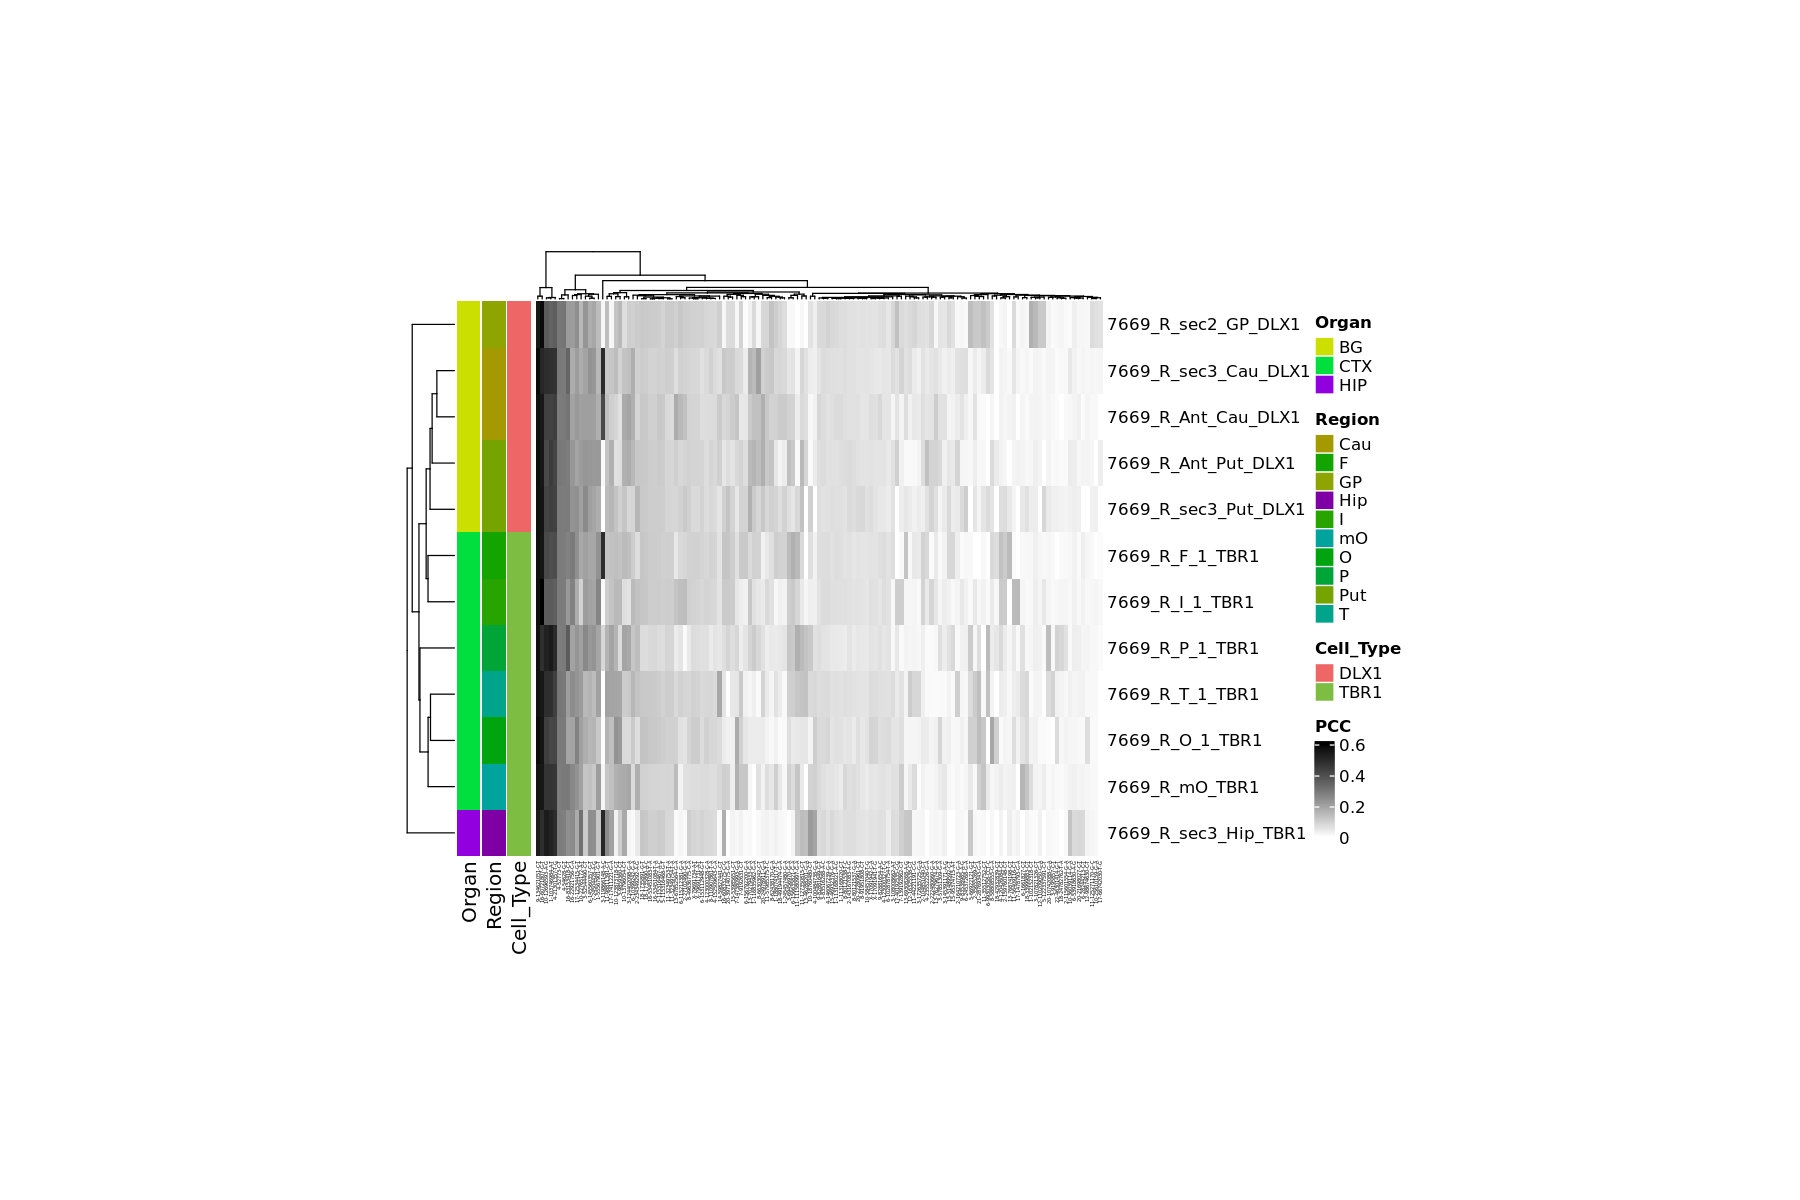

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)
p<-Heatmap(Normalized_casted_MAF_VarBySample2,
        col = c("white", "black"),
        row_names_gp = gpar(fontsize = "10"), column_names_gp = gpar(fontsize = "3"),
        name = "PCC",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(12, "cm"),
        heatmap_height = unit(14, "cm")) 
p

In [9]:
pdf(file="7669_VarBySample_CTX_BG_HIP_heatmap.pdf",height=24,width=40)
p
dev.off()   

png 
  2

# Correlation matrix with selected sorted nuclei and CBH_labeled variants

In [10]:
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Region+Organ+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Hemisphere)
unique(casted_MAF_VarBySample2$Organ)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)

[1] 12

[1] "R"

[1] "BG"  "CTX" "HIP"

[1] "Cau" "Put" "F"   "I"   "mO"  "O"   "P"   "GP"  "Hip" "T"

[1] "DLX1" "TBR1"

In [11]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 12

In [12]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [13]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]
#UMAP<-umap(casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)])

In [14]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 131"
[1] "removed rows due to zero values in all column : 0"
[1] "remaining rows : 131"


In [15]:
colnames(myCol)

[1] "variant_list"                    "sample_number_presented"        
  [3] "HEART"                           "ADRENAL"                        
  [5] "CB"                              "CTX"                            
  [7] "LIVER"                           "KIDNEY"                         
  [9] "POA"                             "BG"                             
 [11] "THAL"                            "SKIN"                           
 [13] "OLF"                             "HIP"                            
 [15] "L"                               "R"                              
 [17] "I"                               "F"                              
 [19] "P"                               "O"                              
 [21] "T"                               "Cau"                            
 [23] "Put"                             "Thal"                           
 [25] "GP"                              "Hip"                            
 [27] "EC"                              "Olf"                            
 [29] "CC"                              "mO"                             
 [31] "Cb"                              "DLX1"                           
 [33] "TBR1"                            "COUPTF2"                        
 [35] "Bulk"                            "NeuN"                           
 [37] "Brain_only"                      "CTX_only"                       
 [39] "BG_only"                         "THAL_only"                      
 [41] "CTX_BG_only"                     "CTX_BG_shared"                  
 [43] "CTX_THAL_shared"                 "Left_only"                      
 [45] "Right_only"                      "sample_number_presented_COUPTF2"
 [47] "HEART_COUPTF2"                   "ADRENAL_COUPTF2"                
 [49] "CB_COUPTF2"                      "CTX_COUPTF2"                    
 [51] "LIVER_COUPTF2"                   "KIDNEY_COUPTF2"                 
 [53] "POA_COUPTF2"                     "BG_COUPTF2"                     
 [55] "THAL_COUPTF2"                    "SKIN_COUPTF2"                   
 [57] "OLF_COUPTF2"                     "HIP_COUPTF2"                    
 [59] "L_COUPTF2"                       "R_COUPTF2"                      
 [61] "I_COUPTF2"                       "F_COUPTF2"                      
 [63] "P_COUPTF2"                       "O_COUPTF2"                      
 [65] "T_COUPTF2"                       "Cau_COUPTF2"                    
 [67] "Put_COUPTF2"                     "Thal_COUPTF2"                   
 [69] "GP_COUPTF2"                      "Hip_COUPTF2"                    
 [71] "EC_COUPTF2"                      "Olf_COUPTF2"                    
 [73] "CC_COUPTF2"                      "mO_COUPTF2"                     
 [75] "Cb_COUPTF2"                      "DLX1_COUPTF2"                   
 [77] "TBR1_COUPTF2"                    "COUPTF2_COUPTF2"                
 [79] "Bulk_COUPTF2"                    "NeuN_COUPTF2"                   
 [81] "Brain_only_COUPTF2"              "CTX_only_COUPTF2"               
 [83] "BG_only_COUPTF2"                 "THAL_only_COUPTF2"              
 [85] "CTX_BG_only_COUPTF2"             "CTX_BG_shared_COUPTF2"          
 [87] "CTX_THAL_shared_COUPTF2"         "Left_only_COUPTF2"              
 [89] "Right_only_COUPTF2"              "IN_only_COUPTF2"                
 [91] "COUP_only_COUPTF2"               "TBR_only_COUPTF2"               
 [93] "TBR_BR_COUPTF2"                  "DLX_BR_COUPTF2"                 
 [95] "sample_number_presented_TBR1"    "CTX_TBR1"                       
 [97] "HIP_TBR1"                        "L_TBR1"                         
 [99] "R_TBR1"                          "I_TBR1"                         
[101] "F_TBR1"                          "P_TBR1"                         
[103] "O_TBR1"                          "T_TBR1"                         
[105] "Hip_TBR1"                        "CTX_only_TBR1"                  
[107] "HIP_only_TBR1"                   "Left_only_TBR1"                 
[109] 

In [16]:
color_list = list(
                CTX = colorRamp2(c(0, 1), c("#ffffff", "#00DF3D")),
                BG = colorRamp2(c(0, 1), c("#ffffff", "#CBDF00")),
                HIP = colorRamp2(c(0, 1), c("#ffffff", "#9200DF")), 
                CTX_BG_shared = colorRamp2(c(0, 1), c("#ffffff", "#DE7058")),
                HIP_BG_shared = colorRamp2(c(0, 1), c("#ffffff", "#A1E843")),
                CTX_HIP_shared = colorRamp2(c(0, 1), c("#ffffff", "#284EED")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        CTX = myCol$CTX_CBH,
                                        BG = myCol$BG_CBH,
                                        HIP = myCol$HIP_CBH,
                                        CTX_BG_shared = myCol$CTX_BG_shared_CBH,
                                        HIP_BG_shared = myCol$BG_HIP_shared_CBH,
                                        CTX_HIP_shared = myCol$CTX_HIP_shared_CBH,
 
                                        col = color_list
                                    #    annotation_legend_param = legendDets
                                        )


In [17]:
left_right_cell_col_ann

A HeatmapAnnotation object with 6 annotations
  name: heatmap_annotation_1 
  position: row 
  items: 131 
  width: 13.757299017573mm 
  height: 1npc 
  this object is subsettable
  12.0574666666667mm extension on the bottom 

           name   annotation_type color_mapping width
            CTX continuous vector  user-defined   2mm
             BG continuous vector  user-defined   2mm
            HIP continuous vector  user-defined   2mm
  CTX_BG_shared continuous vector  user-defined   2mm
  HIP_BG_shared continuous vector  user-defined   2mm
 CTX_HIP_shared continuous vector  user-defined   2mm

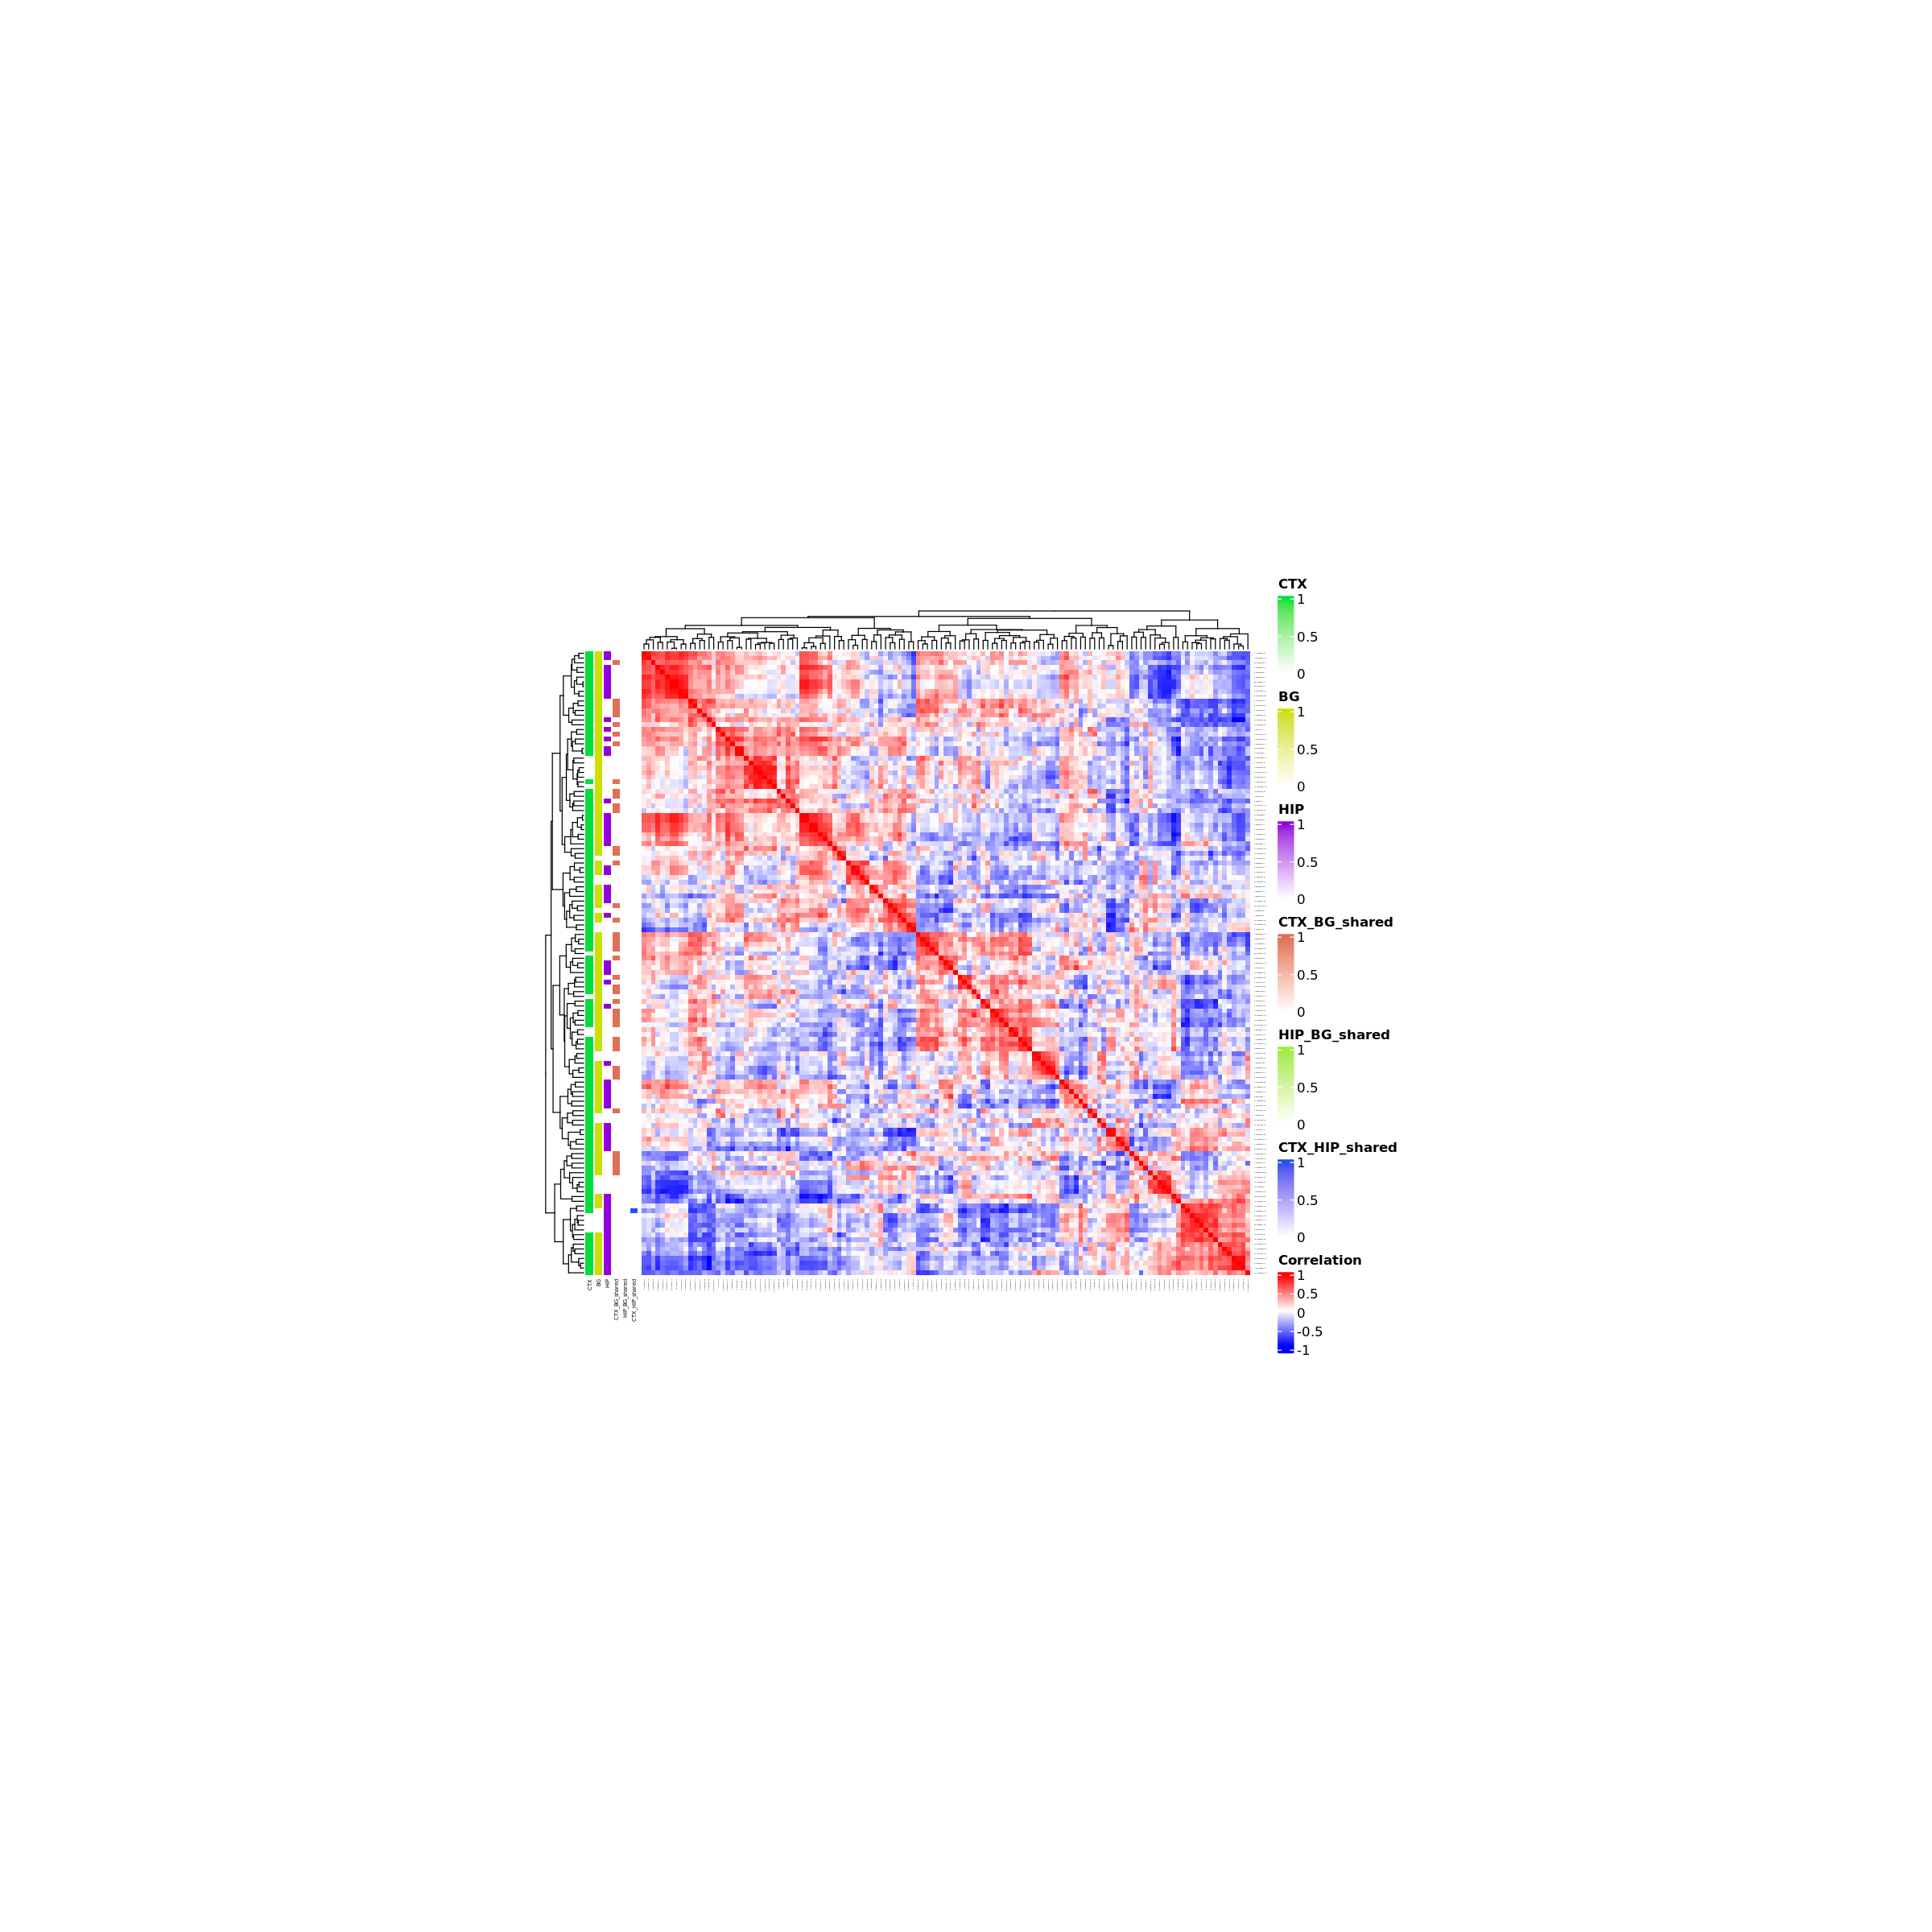

In [18]:
options(repr.plot.width=20, repr.plot.height=20)
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [19]:
pdf(file="7669_CTX_BG_HIP_VarByVar_cor.pdf",height=50,width=50)
complexheatmap
dev.off()

png 
  2

# Bias plot with bulk data

In [20]:
working_variants<-shared_variant_list$variant_list
CTX <- subset(melt_mtcars, Organ %in% c('CTX'))
BG <- subset(melt_mtcars, Organ %in% c('BG'))
HIP <- subset(melt_mtcars, Organ %in% c('HIP'))
length(working_variants)
sum(CTX$MAF, na.rm = TRUE)/length(CTX$MAF)
sum(BG$MAF, na.rm = TRUE)/length(BG$MAF)
sum(HIP$MAF, na.rm = TRUE)/length(HIP$MAF)

delta<-data.frame()
for (i in 1:length(working_variants)){
    xx<-subset(CTX, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(BG, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,1]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

for (i in 1:length(working_variants)){
    xx<-subset(CTX, CHROM.POS.REF.ALT==working_variants[i])
    yy<-subset(HIP, CHROM.POS.REF.ALT==working_variants[i])
    avg_xx<-mean(xx$MAF, na.rm=TRUE) 
    avg_yy<-mean(yy$MAF, na.rm=TRUE)
    avg_xx
    avg_yy
    delta[i,2]<-abs((avg_xx-avg_yy)/max(avg_xx,avg_yy))
    }

[1] 131

[1] 0.09250241

[1] 0.09572251

[1] 0.08785328

In [ ]:
mean(delta[,1])
mean(delta[,2])
SEM_X<-sd(delta[,1]) / sqrt(length(delta[,1]))
SEM_Y<-sd(delta[,2]) / sqrt(length(delta[,2]))
lowerX<-mean(delta[,1])-SEM_X
upperX<-mean(delta[,1])+SEM_X
lowerY<-mean(delta[,2])-SEM_Y
upperY<-mean(delta[,2])+SEM_Y

ERROR: Error in eval(expr, envir, enclos): object 'delta' not found


png 
  2

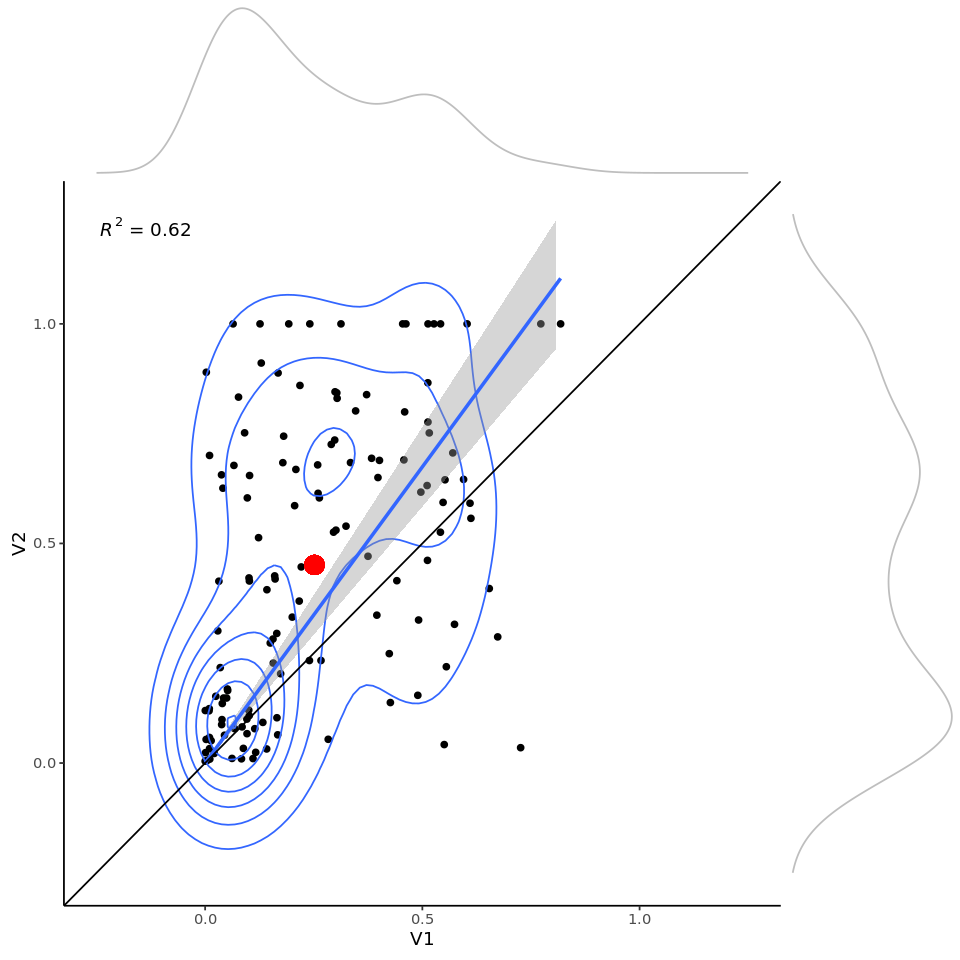

In [22]:
options(repr.plot.width = 8, repr.plot.height = 8)
formula <- y ~ x+0
p<-ggplot(delta, aes(x=V1, y=V2)) + geom_point()+xlim(-0.25,1.25)+ylim(-0.25,1.25)+theme_classic()+
    geom_density_2d()+stat_smooth(method = "lm", formula = y ~ x+0, geom = "smooth")+geom_abline(slope=1, intercept=0)+stat_poly_eq(formula = y ~ x+0,method = "lm")+
    geom_point(x = mean(delta[,1]), y = mean(delta[,2]), aes(x, y), size = 5, color = "red")
ggMarginal(p, color="grey", size=4)
pdf(file="7669_Bulk_CTX_BG_HIP_bias_plot.pdf",height=8,width=8)
 ggMarginal(p, color="grey", size=4)
 dev.off()    

# Bar graph for CTX BG HIP shared variant number

In [6]:
data<-as.data.frame(c(43,0,1))
colnames(data)<-"number"
rownames(data)<-c("CTX-BG","BG-HIP","CTX-HIP")
data

,number
,<dbl>
CTX-BG,43
BG-HIP,0
CTX-HIP,1


In [15]:
xxx<-factor(rownames(data), level=c("CTX-BG","BG-HIP","CTX-HIP"))
options(repr.plot.width=5,repr.plot.height=6)
p<-ggplot(data=data, aes(x=xxx, y=number, fill=xxx)) +
geom_bar(colour="black",stat='identity')+theme_classic() + labs(x='Variant properties', colour = "Variant properties", fill="Variant properties")+
geom_text(aes(label=data$number, vjust = -0.5, size=2)) + theme(axis.text.x=element_text(angle=45, hjust=1))

In [17]:
pdf(file="7669_CTX_BG_HIP_exclusively_shared_var.pdf",height=6,width=5)
p
dev.off()

png 
  2